In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import scanpy as sc
from sklearn.metrics import (
    silhouette_score, 
    adjusted_rand_score, 
    normalized_mutual_info_score,
    homogeneity_score,
)
import anndata as AnnData
import scvi
from scvi.model import SCVI
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

sys.path.append(os.path.abspath("../src"))
from model import InformedSCVI  # type: ignore
from pathway import get_pathway_masks, get_random_masks, filter_genes # type: ignore
from train import plot_loss, split_train_val # type: ignore

warnings.simplefilter("ignore")
sc.logging.print_header()
sc.settings.figsize = (10, 10)
sc.settings.figdir = "../results/figures/"
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sns.set_theme()
torch.set_float32_matmul_precision("high")

c:\Users\mlsar\anaconda3\envs\scvi\Lib\site-packages\docrep\decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
c:\Users\mlsar\anaconda3\envs\scvi\Lib\site-packages\docrep\decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
Seed set to 0


Last run with scvi-tools version: 1.3.0


In [4]:
all_metrics = pd.read_csv("../results/models/all_metrics.csv")
all_metrics

,elbo,reconstruction_error,silhouette,ARI,NMI,homogeneity,model
0,-394.793030,371.170837,0.244466,0.499125,0.699305,0.579440,scVI_hvg
1,-376.606812,352.846680,0.258734,0.499235,0.695759,0.574332,scVI_hvg_funct
2,-472.877838,452.022919,0.179454,0.282951,0.530145,0.377398,piscVI
3,-480.731659,464.570129,0.207461,0.298122,0.552100,0.402085,piscVI_pathways
4,-467.890869,448.629761,0.207239,0.434997,0.636866,0.502521,piscVI_rnd
5,-481.374481,467.885529,0.211973,0.281293,0.512737,0.375621,piscVI_pathways_rnd
6,-472.967926,451.906097,0.187001,0.247255,0.482400,0.328858,piscVI_zinb_lrelu
7,-470.316772,449.851074,0.146870,0.244691,0.477641,0.325550,piscVI_zinb_tanh
8,-471.512390,455.599365,0.183107,0.247309,0.482946,0.329298,piscVI_zinb_sigmoid
9,-475.178101,454.100677,0.215245,0.287506,0.533276,0.380489,piscVI_nb_relu


In [21]:
adata_test = sc.read("../data/NBlarge/sn_tumor_cells_NB_hvg.h5ad")
# adata_test = adata_test[:, ~adata_test.var['ensembl_gene_id'].isna()].copy()

In [22]:
# I need the gene names and not the ensembl ids
adata_test.var_names = adata_test.var['gene_name'].copy()
adata_test.var_names.to_list()

['HES4',
 'ISG15',
 'ACAP3',
 'DVL1',
 'VWA1',
 'CFAP74',
 'PRKCZ',
 'HES5',
 'PRDM16',
 'ARHGEF16',
 'TP73',
 'SMIM1',
 'AJAP1',
 'CHD5',
 'RPL22',
 'HES2',
 'TNFRSF25',
 'UTS2',
 'TNFRSF9',
 'PARK7',
 'ERRFI1',
 'RERE',
 'ENO1',
 'SLC2A5',
 'H6PD',
 'SPSB1',
 'CASZ1',
 'NPPB',
 'DHRS3',
 'C1orf158',
 'PRAMEF10',
 'LRRC38',
 'KAZN',
 'TMEM51',
 'FHAD1',
 'CASP9',
 'SRARP',
 'HSPB7',
 'NBPF1',
 'PADI1',
 'ACTL8',
 'IGSF21',
 'KLHDC7A',
 'IFFO2',
 'HTR6',
 'TMCO4',
 'PLA2G2A',
 'PLA2G5',
 'VWA5B1',
 'ALPL',
 'USP48',
 'HSPG2',
 'LACTBL1',
 'GRHL3',
 'RCAN3',
 'CLIC4',
 'AL020996.2',
 'STMN1',
 'TRIM63',
 'SH3BGRL3',
 'ZNF683',
 'TRNP1',
 'SYTL1',
 'FCN3',
 'IFI6',
 'THEMIS2',
 'RAB42',
 'OPRD1',
 'EPB41',
 'NKAIN1',
 'HDAC1',
 'HPCA',
 'TMEM54',
 'RNF19B',
 'PHC2',
 'CSMD2',
 'GJB4',
 'NCDN',
 'CLSPN',
 'COL8A2',
 'THRAP3',
 'GRIK3',
 'ZC3H12A',
 'POU3F1',
 'NDUFS5',
 'COL9A2',
 'EDN2',
 'CCDC30',
 'CLDN19',
 'MPL',
 'ATP6V0B',
 'KLF17',
 'KIF2C',
 'BTBD19',
 'PRDX1',
 'DMBX1',
 'CYP4A2

In [23]:
#'nFeature_RNA', 'Stage_Code', 'Tissue', 'Risk_Category', 'First_Avail_TP', 'MYCN_Status', 'ALK_Status', 'TP53_Status', 'Response', 'Vital_Status', 'Age_at_IDX_in_months', 'Treatment', 'First_Avail_Time_Point', '', 'biospecimen_id', 'percent.mt', 'seurat_clusters', 'sample_label_wo_prefix', 'S.Score', 'G2M.Score', 'Phase', 'malignancy', 'cell_state', 'RNA_snn_res.0.2', 'MES_Score', 'ADRN_Score', 'MES_ADRN_diff', 'Event', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'disease_ontology_term_id', 'tissue_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'

adata_test.obs['Response'].value_counts()

Response
Partial           76910
Complete          61853
Progressive       28044
Stable Disease    27346
Name: count, dtype: int64

In [24]:
genes_per_pathway, genes_per_circuit, circuits_per_pathway = get_pathway_masks("KEGG_NB")
adata_test, genes_per_pathway, genes_per_circuit, circuits_per_pathway = filter_genes(adata_test, genes_per_pathway, genes_per_circuit, circuits_per_pathway)
masks = [genes_per_circuit, circuits_per_pathway]
print(f"Masks dimensions: {[mask.shape for mask in masks]}")
masks = [genes_per_pathway]
print(f"Masks dimensions: {[mask.shape for mask in masks]}")

Current directory: c:\Users\mlsar\Documents\PISCVI\piVAE\notebooks
Masks dimensions: [(634, 600), (26, 634)]
Masks dimensions: [(26, 600)]


In [14]:
masks = [genes_per_pathway]
print(f"Masks dimensions: {[mask.shape for mask in masks]}")

Masks dimensions: [(1615, 4011)]


In [ ]:
adata_test.copy()

In [6]:
adata = sc.read("../data/NBsmall/NB.bone.Met_preprocessed.h5ad")
# sc.pp.highly_variable_genes(
#     adata, batch_key="sample", flavor="seurat_v3", layer="RNA", n_top_genes=5000, subset=True
# )
adata = adata[:, ~adata.var['ensembl_gene_id'].isna()]

Only considering the two last: ['.Met_preprocessed', '.h5ad'].
Only considering the two last: ['.Met_preprocessed', '.h5ad'].


In [7]:
adata

View of AnnData object with n_obs × n_vars = 36763 × 19064
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [8]:
genes_per_pathway, genes_per_circuit, circuits_per_pathway = get_pathway_masks("KEGG_NB")
adata, genes_per_pathway, genes_per_circuit, circuits_per_pathway = filter_genes(adata, genes_per_pathway, genes_per_circuit, circuits_per_pathway)
frac = genes_per_circuit.sum(axis=1).mean() / genes_per_circuit.shape[1]
rnd_genes_per_pathway, rnd_genes_per_circuit, rnd_circuits_per_pathway = get_random_masks(adata.var_names, genes_per_circuit.shape[0], genes_per_pathway.shape[0], frac=frac, seed=42)

masks_keggNB = [genes_per_circuit, circuits_per_pathway]
print(f"Masks dimensions: {[mask.shape for mask in masks_keggNB]}")
masks_keggNB_rnd = [rnd_genes_per_circuit, rnd_circuits_per_pathway]
masks_keggNB_pathways = [genes_per_pathway]
print(f"Masks dimensions: {[mask.shape for mask in masks_keggNB_pathways]}")
masks_keggNB_pathways_rnd = [rnd_genes_per_pathway]

Current directory: c:\Users\mlsar\Documents\PISCVI\piVAE\notebooks
Masks dimensions: [(634, 1839), (26, 634)]
Masks dimensions: [(26, 1839)]


In [26]:
layer = "RNA"
key = "piscVI"
masks = masks_keggNB

In [16]:
#adata = adata.copy()
InformedSCVI.setup_anndata(
    adata,
    layer=layer,
    batch_key="sample",
)

setup_anndata: InformedSCVI


In [ ]:
print(type(masks))
model = InformedSCVI(
    adata,
    gene_likelihood=likelihood,
    activation=activation,
    masks=masks,
)

In [ ]:
# Train model
train_indices, val_indices = split_train_val(adata)
early_stopping_kwargs = {
    "early_stopping": True,
    "early_stopping_patience": 30,
    "early_stopping_monitor": "validation_loss",
}
datasplitter_kwargs = {
    "external_indexing": [train_indices, val_indices],
}
model.train(datasplitter_kwargs=datasplitter_kwargs, **early_stopping_kwargs) 

# Save model
model.save(f"../results/models/{key}", overwrite=True, save_anndata=False)

In [ ]:
# Save latent representation
latent = model.get_latent_representation()
adata.obsm[f"X_{key}"] = latent

In [27]:
#adata = adata.copy()
model = InformedSCVI.load(f"../results/models/{key}", adata=adata)

INFO     File ../results/models/piscVI\model.pt already downloaded                                                 
setup_anndata: InformedSCVI


In [28]:
model.module

InformedVAE(
  (z_encoder): InformedEncoder(
    (encoder): InformedFCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=1839, out_features=634, bias=True)
          (1): BatchNorm1d(634, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=634, out_features=26, bias=True)
          (1): BatchNorm1d(26, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=26, out_features=13, bias=True)
    (var_encoder): Linear(in_features=26, out_features=13, bias=True)
  )
  (l_encoder): InformedEncoder(
    (encoder): InformedFCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linea

In [ ]:
plot_loss(model, save_path=f"../results/figures/{key}/loss.png")

# Save normalized expression
adata_subset = adata[adata.obs.cell1 == "Tumor"]
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised = pd.DataFrame(
    denoised,
    index=adata_subset.obs_names,
    columns=adata_subset.var_names,
)
os.makedirs(f"../results/models/{key}", exist_ok=True)
denoised.to_csv(f"../results/models/{key}/denoised_data.csv")

In [ ]:
# Clustering
sc.pp.neighbors(adata, use_rep=f"X_{key}", key_added=f"neighbors_{key}")
sc.tl.umap(adata, min_dist=0.3, key_added=f"umap_{key}", neighbors_key=f"neighbors_{key}")
sc.tl.leiden(adata, key_added=f"leiden_{key}", resolution=0.1, neighbors_key=f"neighbors_{key}")
sc.settings.figdir = f"../results/figures/{key}/"
for feature in ["leiden", "cell1", "cell2", "sample"]:
    sc.pl.embedding(adata, basis=f"umap_{key}", color=feature, title=feature, frameon=False, show=False, save=f"_{feature}.png")



In [ ]:
# Calculate metrics
elbo = model.get_elbo().item()
reconstruction_error = model.get_reconstruction_error()['reconstruction_loss'].item()
silhouette = silhouette_score(adata.obsm[f"X_{key}"], adata.obs[f"leiden_{key}"], metric="euclidean")
ARI = adjusted_rand_score(adata.obs["cell2"], adata.obs[f"leiden_{key}"])
NMI = normalized_mutual_info_score(adata.obs["cell2"], adata.obs[f"leiden_{key}"])
homogeneity = homogeneity_score(adata.obs["cell2"], adata.obs[f"leiden_{key}"])
metrics = pd.DataFrame(
    {
        "elbo": [elbo],
        "reconstruction_error": [reconstruction_error],
        "silhouette": [silhouette],
        "ARI": [ARI],
        "NMI": [NMI],
        "homogeneity": [homogeneity],
    }
)
metrics.to_csv(f"../results/models/{key}/metrics.csv", index=False)

In [41]:
activations = model.get_hidden_activations(layers_to_capture=[0,1])
activations

{'layer_0': array([[ 8.05735111e-01, -2.99244940e-01,  2.17118454e+00, ...,
         -2.67577887e-01, -1.12988077e-01, -1.20785981e-02],
        [-1.49340010e+00, -3.22933435e+00,  2.33590245e+00, ...,
         -2.88970351e-01, -4.06079113e-01, -1.20785981e-02],
        [-3.90195608e-01, -5.87054729e-01,  2.23462415e+00, ...,
          7.28143930e-01,  5.75884283e-01, -1.15581811e-03],
        ...,
        [ 7.12477565e-01, -3.16614881e-02,  1.45731759e+00, ...,
          1.41693980e-01,  1.08375780e-01, -1.15581811e-03],
        [ 4.81680959e-01,  1.19119875e-01,  1.04714110e-01, ...,
         -5.56621179e-02, -1.59578584e-02, -1.15581811e-03],
        [-1.46802187e-01, -4.13029194e-02,  8.77713040e-02, ...,
         -3.32080096e-01, -5.83479404e-02, -7.56186485e-01]], dtype=float32),
 'layer_1': array([[  0.77141124,  -3.0970814 ,   9.285284  , ...,   1.8954625 ,
          -0.39454713,  -0.38066736],
        [ -3.841688  ,  -2.1419477 ,   9.619922  , ...,   0.9588888 ,
           0.0

In [44]:
type(circuit_activations)

pandas.core.frame.DataFrame

In [76]:
pathway_activations = pd.DataFrame(
    activations['layer_1'],
    index=adata.obs_names,
    #pathway names from genes_per_pathway
    columns= [genes_per_pathway.index[i] for i in range(genes_per_pathway.shape[0])],
)
circuit_activations = pd.DataFrame(
    activations['layer_0'],
    index=adata.obs_names,
    #circuit names from genes_per_circuit
    columns= [genes_per_circuit.index[i] for i in range(genes_per_circuit.shape[0])],
)

In [ ]:
circuit_adata = sc.AnnData(X=circuit_activations.abs())
circuit_adata.obs = adata.obs.copy()

pathway_adata = sc.AnnData(X=pathway_activations.abs())
pathway_adata.obs = adata.obs.copy()


In [ ]:
sc.pp.neighbors(circuit_adata, use_rep="X", random_state=42)
sc.tl.leiden(circuit_adata, random_state=42)
sc.tl.umap(circuit_adata, random_state=42)

sc.pp.neighbors(pathway_adata, use_rep="X", random_state=42)
sc.tl.leiden(pathway_adata, random_state=42)
sc.tl.umap(pathway_adata, random_state=42)

In [ ]:
circuit_adata

AnnData object with n_obs × n_vars = 36763 × 634
    obs: 'leiden'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
method = "wilcoxon"
nb_adata = pathway_adata[pathway_adata.obs["cell1"].isin(["Tumor", "progenitor"])].copy()
nb_adata.obs["cell1"].value_counts()


cell1
Tumor         1327
progenitor     959
Name: count, dtype: int64

In [69]:
# Run differential expression analysis comparing INSS_stage 4 vs. 4S
sc.tl.rank_genes_groups(
    nb_adata,
    "cell1",  # Condition to compare
    reference="progenitor",  # Reference group
    key_added=method,
    method=method
)

result = nb_adata.uns[method]
dacs = pd.DataFrame(
    {
        key: result[key]['Tumor']
        for key in ["names", "scores", "pvals", "pvals_adj", "logfoldchanges"]
    }
)

dacs.head(30)

,names,scores,pvals,pvals_adj,logfoldchanges
0,hsa04924,35.027916,8.458699e-269,2.199262e-267,5.841978
1,hsa04927,29.857382,7.040773e-196,9.153005e-195,14.325462
2,hsa04115,28.121006,5.423463e-174,4.700334e-173,10.858342
3,hsa04024,27.739975,2.302049e-169,1.496332e-168,28.416481
4,hsa04015,25.580639,2.505659e-144,1.085785e-143,1.657217
5,hsa04330,12.349091,4.926531e-35,1.164453e-34,1.966120
6,hsa05200,12.124382,7.844954e-34,1.699740e-33,2.114467
7,hsa04012,7.966303,1.634922e-15,3.036283e-15,0.833007
8,hsa04740,7.093091,1.311495e-12,2.273259e-12,1.023052
9,hsa04066,6.302486,2.929079e-10,4.479768e-10,-1.561164


In [70]:
dacs

,names,scores,pvals,pvals_adj,logfoldchanges
0,hsa04924,35.027916,8.458699e-269,2.199262e-267,5.841978
1,hsa04927,29.857382,7.040773e-196,9.153005e-195,14.325462
2,hsa04115,28.121006,5.423463e-174,4.700334e-173,10.858342
3,hsa04024,27.739975,2.302049e-169,1.496332e-168,28.416481
4,hsa04015,25.580639,2.505659e-144,1.085785e-143,1.657217
5,hsa04330,12.349091,4.926531e-35,1.164453e-34,1.966120
6,hsa05200,12.124382,7.844954e-34,1.699740e-33,2.114467
7,hsa04012,7.966303,1.634922e-15,3.036283e-15,0.833007
8,hsa04740,7.093091,1.311495e-12,2.273259e-12,1.023052
9,hsa04066,6.302486,2.929079e-10,4.479768e-10,-1.561164


In [ ]:
dacs_to_write = dacs.head(40).copy()
dacs_to_write = dacs_to_write.rename(columns={"names": "pathways"})
dacs_to_write = dacs_to_write.drop("pvals", axis=1)

dacs_to_write["pathways"] = (
    dacs_to_write["pathways"]
    .str.replace("signaling pathway", "")
    .str.replace(" sathway", "")
    .str.replace(" :", ":")
)
dacs_to_write.to_latex(
    "../results/ivae_scorer_kegg.tex",
    float_format="%.2f",
    index=False,
    escape=True,
)

dacs_to_write

,pathways,scores,pvals_adj,logfoldchanges
0,hsa04924,35.027916,2.199262e-267,5.841978
1,hsa04927,29.857382,9.153005e-195,14.325462
2,hsa04115,28.121006,4.700334e-173,10.858342
3,hsa04024,27.739975,1.496332e-168,28.416481
4,hsa04015,25.580639,1.085785e-143,1.657217
5,hsa04330,12.349091,1.164453e-34,1.966120
6,hsa05200,12.124382,1.699740e-33,2.114467
7,hsa04012,7.966303,3.036283e-15,0.833007
8,hsa04740,7.093091,2.273259e-12,1.023052
9,hsa04066,6.302486,4.479768e-10,-1.561164


In [81]:
dacs_top = dacs["names"][:10]
# dacs_top = dacs_top[dacs_top.str.contains("interferon|ifn", case=False)]
dacs_top

0    hsa04924
1    hsa04927
2    hsa04115
3    hsa04024
4    hsa04015
5    hsa04330
6    hsa05200
7    hsa04012
8    hsa04740
9    hsa04066
Name: names, dtype: object

In [84]:
names_to_plot = (
    dacs_top.tolist()
)

adata.obsm["pathways"] = pathway_activations.abs()
adata.obs[names_to_plot] = adata.obsm["pathways"][dacs_top]

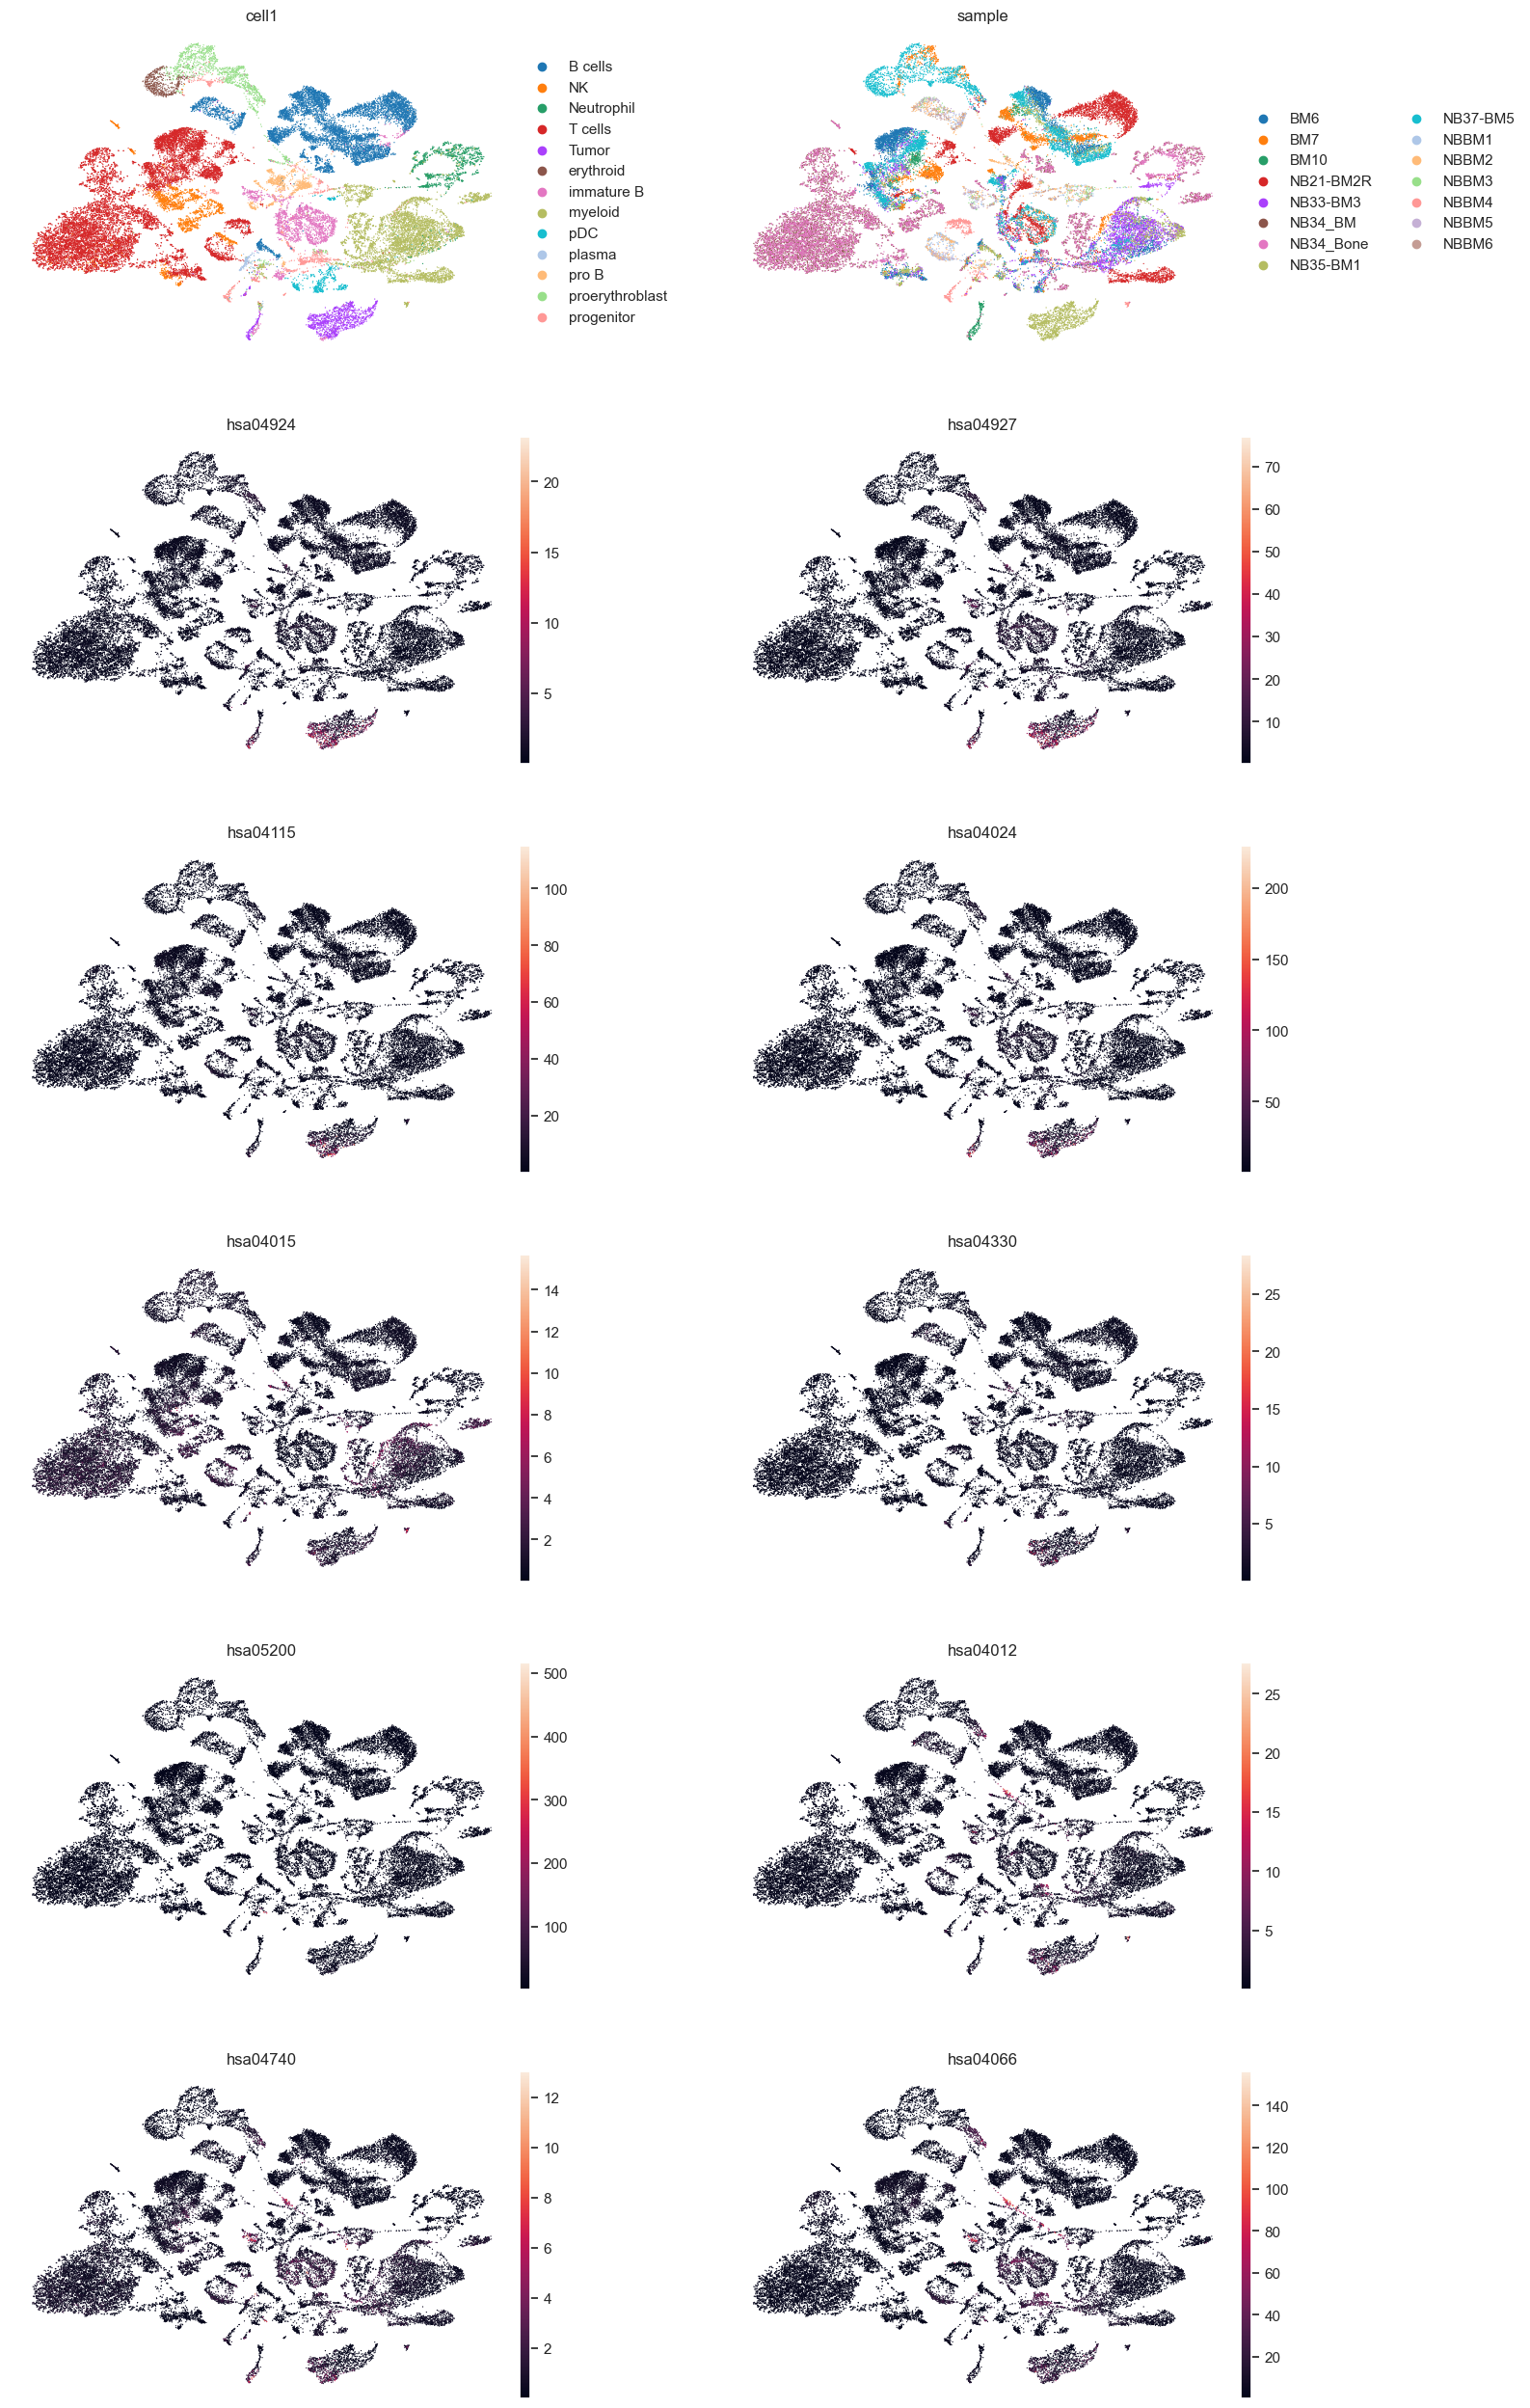

In [85]:
sc.pl.umap(
    adata,
    color=["cell1", "sample"]   + names_to_plot,
    frameon=False,
    ncols=2,
    wspace=0.3,
    show=True,
)
